# Integrative Feature Analysis

In this notebook, I explore clustering analysis based on **histological**, **molecular**, and **integrative** features, with the goal of assessing whether combining different types of information improves cell-type discrimination.

Using **unsupervised clustering techniques**, I compare the performance of individual feature types against integrated ones, focusing on:

- **cluster stability**,
- **consistency with biological labels** derived from molecular analysis,
- and clustering comparison metrics (e.g., **ARI** and **Jaccard Index**).

As in the previous analyses, I focus on epithelial cells from breast cancer samples profiled with spatial transcriptomics.

## Library Imports

This section includes the necessary libraries for data handling, statistical analysis, and visualization.

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import spatialdata as sd
import cellcharter as cc

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score

from scipy.stats import ks_2samp, mannwhitneyu

## Dataset Loading

I load the following datasets:

- `xenium`: the full spatial transcriptomics dataset.
- `epithelial_cells`: a subset containing only epithelial cells.
- `molecular_features`: molecular features extracted from the dataset.
- `histological_features`: histological features computed from tissue images.
- `integrative_features`: combined features (molecular + histological).

In [23]:
xenium = sd.read_zarr("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC.zarr")

In [24]:
epithelial_cells = sc.read_h5ad("epithelial_cells_cell_type_prediction_filtered.h5ad")

In [25]:
molecular_features = pd.read_csv("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_molecular_mild-dawn-408.csv")

In [26]:
histological_features = pd.read_csv("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_phikon_icy-salad-378.csv")

In [27]:
integrative_features = pd.read_csv("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_multi_proud_rain_419.csv")

## Adding Features to AnnData Objects

The features are added to the corresponding `AnnData` objects as alternative representations (`obsm`).  
Feature names are also stored for future use.

In [28]:
def create_feature_anndata(epithelial_cells, feature_df, obsm_key):
    # If 'cell_id' is a column, set it as the index
    if "cell_id" in feature_df.columns:
        feature_df = feature_df.set_index("cell_id")

    # Convert to string for alignment
    obs_ids = epithelial_cells.obs['cell_id'].astype(str)
    feature_df.index = feature_df.index.astype(str)

    # Find common cells
    common_cells = obs_ids[obs_ids.isin(feature_df.index)]
    adata_filtered = epithelial_cells[common_cells.index].copy()

    # Align features in the correct order
    feature_aligned = feature_df.loc[common_cells]

    # Insert features
    adata_filtered.obsm[obsm_key] = feature_aligned.astype("float32").to_numpy()
    adata_filtered.uns[obsm_key + "_feature_names"] = feature_aligned.columns.tolist()

    print(f"Features added to `{obsm_key}`. {adata_filtered.n_obs} cells, {feature_aligned.shape[1]} features.")
    return adata_filtered

# Add features derived from the full dataset to AnnData objects
adata_molecular_features = create_feature_anndata(epithelial_cells, molecular_features, "molecular_features")
adata_histological_features = create_feature_anndata(epithelial_cells, histological_features, "histological_features")
adata_integrative_features = create_feature_anndata(epithelial_cells, integrative_features, "integrative_features")

Features added to `molecular_features`. 348692 cells, 32 features.
Features added to `histological_features`. 348692 cells, 32 features.
Features added to `integrative_features`. 348692 cells, 32 features.


## Clustering with ClusterAutoK on Unscaled Features

The `ClusterAutoK` method is applied to identify the optimal number of clusters for each set of **unscaled** features (molecular, histological, and integrative).  
The resulting models are saved for future analyses.

For **histological features**, both scaled and unscaled versions were tested, but no significant differences were observed, so only the scaled version is used in the final analysis.

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

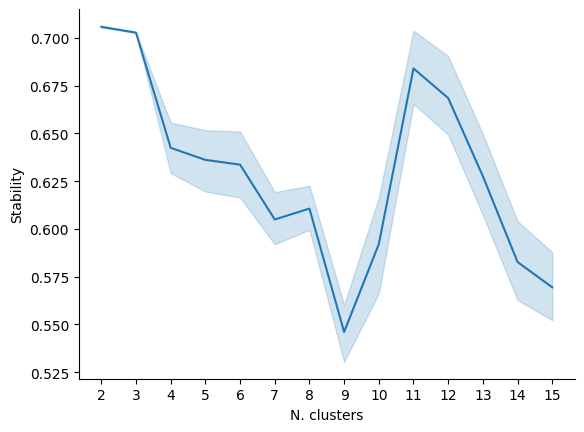

In [11]:
# ClusterAutoK on UNSCALED INTEGRATIVE FEATURES
autok_integrative_features_unscaled = cc.tl.ClusterAutoK(
    n_clusters=(2, 15), 
    max_runs=10,
    convergence_tol=0.001)

autok_integrative_features_unscaled.fit(
    adata_integrative_features, 
    use_rep='integrative_features')

# Plot cluster stability
ax = cc.pl.autok_stability(autok_integrative_features_unscaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "integrative_features_unscaled_autok_plot.pdf", dpi=300)

# Save model
save_path = Path("saved_models_final/integrative_features_unscaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_integrative_features_unscaled.save(save_path, best_k=False)

## Feature Standardization

The `StandardScaler` from scikit-learn is applied to standardize each feature set. 
This step is essential to fairly compare clustering performance between raw and normalized data.

In [29]:
def standardize_features(adata, obsm_key, new_obsm_key):
    scaler = StandardScaler()
    X = adata.obsm[obsm_key]
    X_scaled = scaler.fit_transform(X)
    adata.obsm[new_obsm_key] = X_scaled
    return adata

# Standardize molecular features
adata_molecular_features = standardize_features(
    adata_molecular_features,
    obsm_key="molecular_features",
    new_obsm_key="molecular_features_scaled")

# Standardize histological features
adata_histological_features = standardize_features(
    adata_histological_features,
    obsm_key="histological_features",
    new_obsm_key="histological_features_scaled")

# Standardize integrative features
adata_integrative_features = standardize_features(
    adata_integrative_features,
    obsm_key="integrative_features",
    new_obsm_key="integrative_features_scaled")

## Clustering with ClusterAutoK on Scaled Features

The clustering analysis is repeated using the **scaled** versions of the features (molecular, histological, and integrative). The resulting models are saved again for further analyses.

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

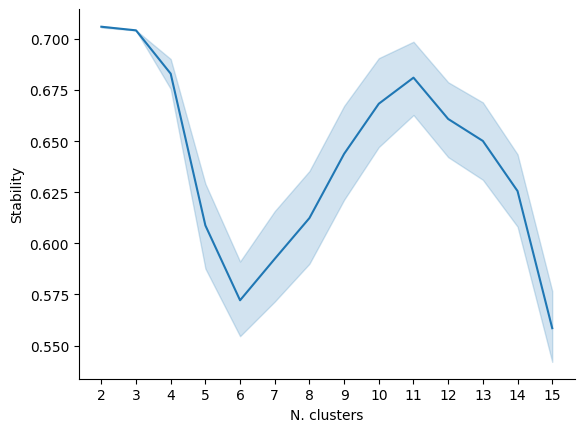

In [13]:
# ClusterAutoK on SCALED INTEGRATIVE FEATURES
autok_integrative_features_scaled = cc.tl.ClusterAutoK(
    n_clusters=(2, 15), 
    max_runs=10,
    convergence_tol=0.001)

autok_integrative_features_scaled.fit(
    adata_integrative_features,
    use_rep='integrative_features_scaled')

# Plot cluster stability
ax = cc.pl.autok_stability(autok_integrative_features_scaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "integrative_features_scaled_autok_plot.pdf", dpi=300)

# Save the model
save_path = Path("saved_models_final/integrative_features_scaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_integrative_features_scaled.save(save_path, best_k=False)

## Cluster Assignment

The saved models are used to assign cluster labels to each cell. The values of `k` are selected based on the stability of the obtained clusterings.

In [30]:
# MOLECULAR FEATURES UNSCALED, k=2
autok_molecular_features_unscaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/molecular_features_unscaled_autok")
adata_molecular_features.obs['cluster_2_unscaled'] = autok_molecular_features_unscaled_loaded.predict(
    adata_molecular_features, use_rep='molecular_features', k=2)

# MOLECULAR FEATURES SCALED, k=2
autok_molecular_features_scaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/molecular_features_scaled_autok")
adata_molecular_features.obs['cluster_2_scaled'] = autok_molecular_features_scaled_loaded.predict(
    adata_molecular_features, use_rep='molecular_features_scaled', k=2)

# HISTOLOGICAL FEATURES SCALED, k=5
autok_histological_features_scaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/histological_features_scaled_autok")
adata_histological_features.obs['cluster_5_scaled'] = autok_histological_features_scaled_loaded.predict(
    adata_histological_features, use_rep='histological_features_scaled', k=5)

# INTEGRATIVE FEATURES UNSCALED, k=3
autok_integrative_features_unscaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/integrative_features_unscaled_autok")
adata_integrative_features.obs['cluster_3_unscaled'] = autok_integrative_features_unscaled_loaded.predict(
    adata_integrative_features, use_rep='integrative_features', k=3)

# INTEGRATIVE FEATURES SCALED, k=3
autok_integrative_features_scaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/integrative_features_scaled_autok")
adata_integrative_features.obs['cluster_3_scaled'] = autok_integrative_features_scaled_loaded.predict(
    adata_integrative_features, use_rep='integrative_features_scaled', k=3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## |log2 Fold-Change| Analysis by Cluster

I assessed cluster separability by calculating the absolute log2 fold-change for each cluster compared to the others. I then compared the distributions between scaled and unscaled data using statistical tests (Kolmogorov–Smirnov and Mann–Whitney).

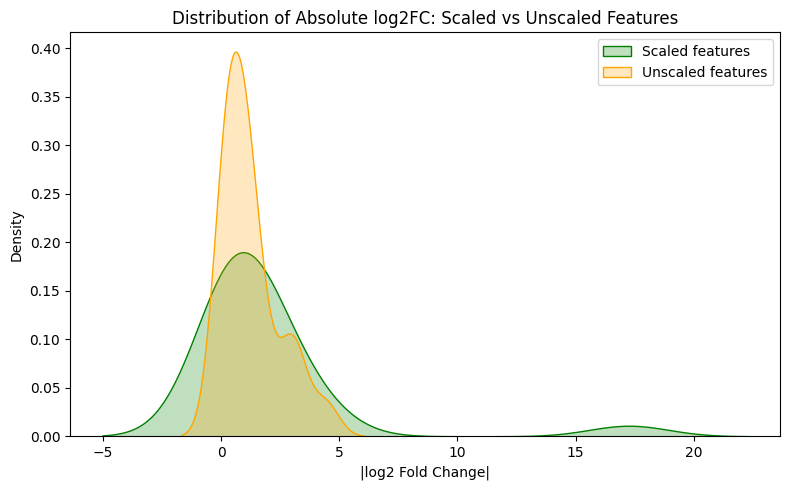


Kolmogorov–Smirnov test: stat = 0.0887, p-value = 9.8560e-01
Mean |log2FC| - Scaled:   1.9459
Mean |log2FC| - Unscaled: 1.2246

Cleaned scaled length:   44
Cleaned unscaled length: 42

Mann–Whitney U test:
  U = 944.0000, p-value = 8.6620e-01


In [18]:
def compute_abs_logfc_per_cluster(adata, cluster_col, features_key):
    """ Compute absolute log2 fold-change (|log2FC|) for each feature per cluster compared to all other clusters. """
    X = adata.obsm[features_key]
    clusters = adata.obs[cluster_col].astype(str).values
    feature_names = adata.uns[features_key + "_feature_names"]
    
    df = pd.DataFrame(X, columns=feature_names, index=adata.obs_names)
    df['cluster'] = clusters

    abs_logfc_all = []

    for cluster in sorted(df['cluster'].unique()):
        df_cluster = df[df['cluster'] == cluster].drop(columns='cluster')
        df_rest = df[df['cluster'] != cluster].drop(columns='cluster')

        mean_cluster = df_cluster.mean() + 1e-9  # avoid division by zero
        mean_rest = df_rest.mean() + 1e-9

        logfc = np.log2(mean_cluster / mean_rest)
        abs_logfc = np.abs(logfc)
        abs_logfc_all.extend(abs_logfc.values)

    return np.array(abs_logfc_all)


def analyze_logfc_distribution(adata, features_key, cluster_col_scaled, cluster_col_unscaled):
    """
    Compare the distribution of absolute log2 fold-changes between scaled and unscaled features
    clustered with given cluster assignments.
    Performs KDE plots and statistical tests (KS and Mann–Whitney U).
    """
    # Compute absolute logFC for scaled and unscaled clusters
    abs_logfc_scaled = compute_abs_logfc_per_cluster(adata, cluster_col_scaled, features_key)
    abs_logfc_unscaled = compute_abs_logfc_per_cluster(adata, cluster_col_unscaled, features_key)

    # Plot KDE distributions
    plt.figure(figsize=(8, 5))
    sns.kdeplot(abs_logfc_scaled, label='Scaled features', fill=True, color='green')
    sns.kdeplot(abs_logfc_unscaled, label='Unscaled features', fill=True, color='orange')
    plt.xlabel('|log2 Fold Change|')
    plt.ylabel('Density')
    plt.title('Distribution of Absolute log2FC: Scaled vs Unscaled Features')
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # Kolmogorov–Smirnov test
    stat, pval = ks_2samp(abs_logfc_scaled[~np.isnan(abs_logfc_scaled)],
                          abs_logfc_unscaled[~np.isnan(abs_logfc_unscaled)])
    print(f"\nKolmogorov–Smirnov test: stat = {stat:.4f}, p-value = {pval:.4e}")

    # Mean absolute log2FC
    print(f"Mean |log2FC| - Scaled:   {np.nanmean(abs_logfc_scaled):.4f}")
    print(f"Mean |log2FC| - Unscaled: {np.nanmean(abs_logfc_unscaled):.4f}")

    # Remove NaNs for Mann–Whitney U test
    scaled_clean = abs_logfc_scaled[~np.isnan(abs_logfc_scaled)]
    unscaled_clean = abs_logfc_unscaled[~np.isnan(abs_logfc_unscaled)]

    print(f"\nCleaned scaled length:   {len(scaled_clean)}")
    print(f"Cleaned unscaled length: {len(unscaled_clean)}")

    # Mann–Whitney U test
    if len(scaled_clean) > 0 and len(unscaled_clean) > 0:
        stat_mwu, pval_mwu = mannwhitneyu(scaled_clean, unscaled_clean, alternative='two-sided')
        print(f"\nMann–Whitney U test:")
        print(f"  U = {stat_mwu:.4f}, p-value = {pval_mwu:.4e}")
    else:
        print("One of the two arrays is empty after removing NaNs.")

# Example usage on molecular features dataset
analyze_logfc_distribution(
    adata=adata_molecular_features,
    features_key='molecular_features',
    cluster_col_scaled='cluster_2_scaled',
    cluster_col_unscaled='cluster_2_unscaled')

## Evaluation with Silhouette Score

I calculated the Silhouette Score to assess the internal consistency of clusters obtained from both scaled and unscaled features.

In [15]:
# Scaled features
X_scaled = adata_molecular_features.obsm['molecular_features_scaled']
labels_scaled = adata_molecular_features.obs['cluster_2_scaled'].astype(str).values

sil_score_scaled = silhouette_score(X_scaled, labels_scaled)
print(f"Silhouette Score (scaled): {sil_score_scaled:.4f}")

# Unscaled features
X_unscaled = adata_molecular_features.obsm['molecular_features']
labels_unscaled = adata_molecular_features.obs['cluster_2_unscaled'].astype(str).values

sil_score_unscaled = silhouette_score(X_unscaled, labels_unscaled)
print(f"Silhouette Score (unscaled): {sil_score_unscaled:.4f}")

Silhouette Score (scaled): 0.0502
Silhouette Score (unscaled): 0.0469


## Biological Analysis of Clusters on Integrated Features

I analyzed the cellular composition of clusters generated using the integrated features, comparing them with the expected cell-type labels (`Malignant`, `Normal`, `Unknown`). I generated heatmaps and percentage fold-changes to visualize the over- or under-representation of each cell type within the clusters.

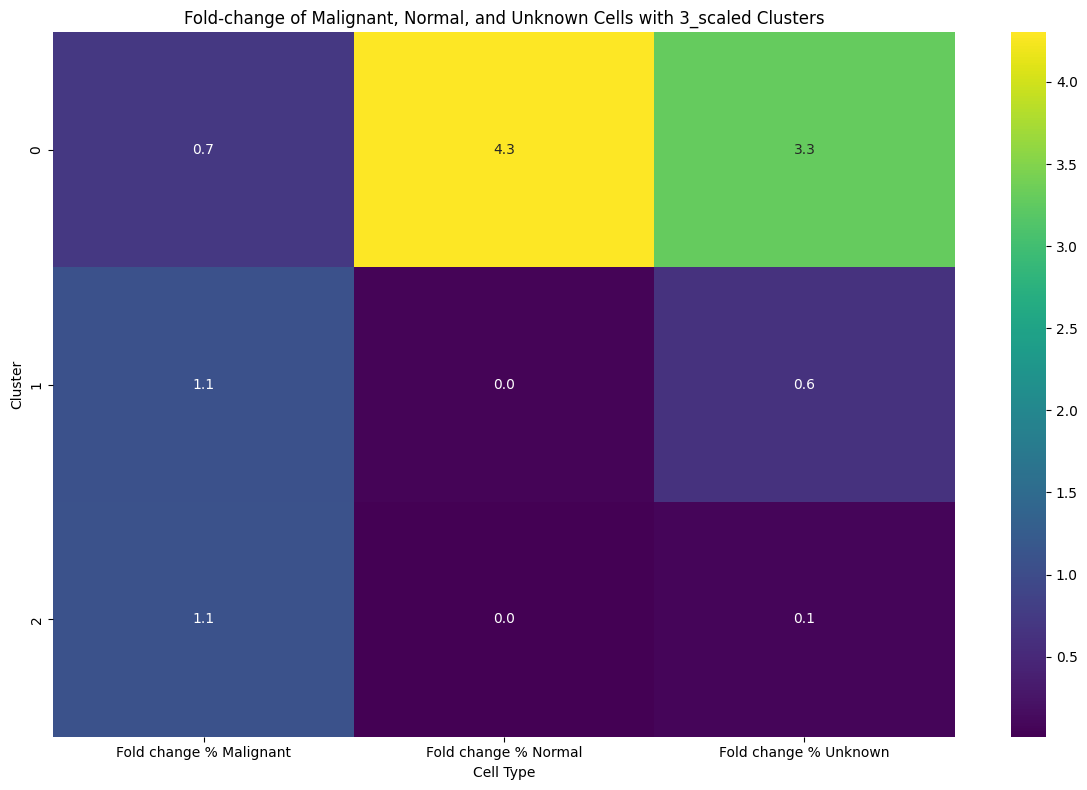

In [12]:
# INTEGRATIVE FEATURES
n_comp = '3_scaled'
adata = adata_integrative_features

cluster_col = f'cluster_{n_comp}'

# Count occurrences of each predicted cell type in the dataset
cell_type_counts = adata.obs['cell_type_prediction'].value_counts()

# Compute the total number of cells
total_cells = cell_type_counts.sum()

# Dynamically calculate overall percentages
malignant_pct_total = (cell_type_counts.get('Malignant', 0) / total_cells) * 100
normal_pct_total = (cell_type_counts.get('Normal', 0) / total_cells) * 100
unknown_pct_total = (cell_type_counts.get('Unknown', 0) / total_cells) * 100

# Contingency table: cluster vs. predicted cell type
crosstab = pd.crosstab(adata.obs[cluster_col], adata.obs['cell_type_prediction'])

# Count table with totals and percentages
cluster_counts = adata.obs.groupby([cluster_col, "cell_type_prediction"]).size().unstack(fill_value=0)
cluster_counts["Total"] = cluster_counts.sum(axis=1)
cluster_counts["Malignant %"] = cluster_counts["Malignant"] / cluster_counts["Total"] * 100
cluster_counts["Normal %"] = cluster_counts["Normal"] / cluster_counts["Total"] * 100
cluster_counts["Unknown %"] = cluster_counts["Unknown"] / cluster_counts["Total"] * 100

# Compute fold-change relative to overall proportions in the dataset
cluster_counts["Fold change % Malignant"] = cluster_counts["Malignant %"] / malignant_pct_total
cluster_counts["Fold change % Normal"] = cluster_counts["Normal %"] / normal_pct_total
cluster_counts["Fold change % Unknown"] = cluster_counts["Unknown %"] / unknown_pct_total

# HEATMAP
filename = f"figures/HEATMAP_{cluster_col}.pdf"

plt.figure(figsize=(12, 8))
sns.heatmap(
    cluster_counts[["Fold change % Malignant", "Fold change % Normal", "Fold change % Unknown"]],
    cmap="viridis", annot=True, fmt=".1f")

plt.title(f"Fold-change of Malignant, Normal, and Unknown Cells with {n_comp} Clusters")
plt.xlabel("Cell Type")
plt.ylabel("Cluster")
plt.tight_layout()
plt.savefig(filename)
plt.show()
plt.close()

# Create a DataFrame with cell IDs and assigned clusters
df_clusters = pd.DataFrame({
    'cell_id': adata.obs_names,  # AnnData index corresponds to cell IDs
    cluster_col: adata.obs[cluster_col].values})

# Save to CSV
output_path = f"results/cluster_value_{cluster_col}.csv"
df_clusters.to_csv(output_path, index=False)

## Reclassification of Unknown Cell Types

I leveraged the cluster composition to reclassify cells previously labeled as `Unknown`, assigning them to either `Malignant` or `Normal` based on their cluster membership. The biological validity of this reclassification was assessed using boxplots of molecular signatures.

reclassified_cluster_3_scaled
Malignant (original)    319136
Normal (original)        25245
Unknown → Normal          3220
Unknown → Malignant       1091
Name: count, dtype: int64
['Malignant', 'Unknown', 'Normal']
Categories (3, object): ['Malignant', 'Normal', 'Unknown']


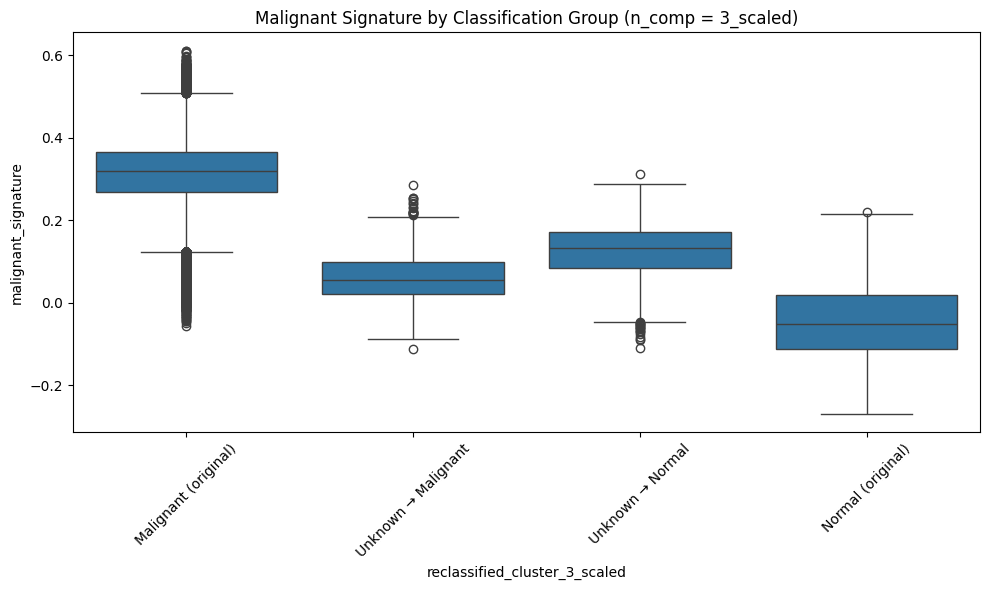

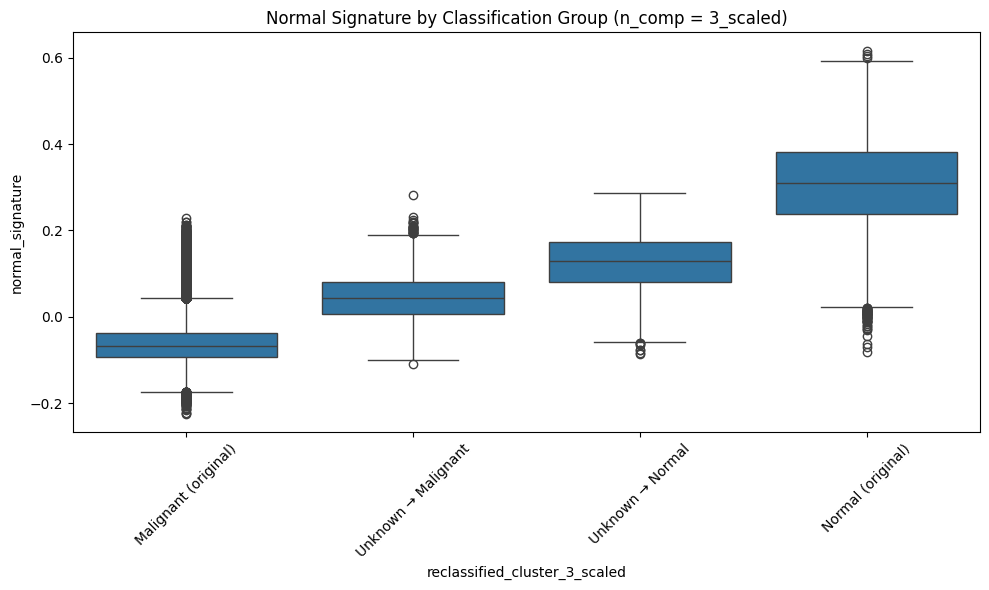

In [13]:
# INTEGRATIVE_FEATURES_SCALED
malignant_clusters = [1, 2]
normal_clusters = [0]

# USE MALIGNANT AND NORMAL SIGNATURES IDENTIFIED FROM MOLECULAR DATA
new_cluster_col = f"new_cluster_{n_comp}"  # Classification into Normal, Malignant, and Unknown based on cluster

# Function to assign a label based on the cluster
def assign_cluster_label(cluster):
    if cluster in malignant_clusters:
        return "Malignant"
    elif cluster in normal_clusters:
        return "Normal"
    elif cluster in unknown_clusters:
        return "Unknown"
    else:
        return "Undefined"

# Apply function to assign labels
adata.obs[new_cluster_col] = adata.obs[cluster_col].apply(assign_cluster_label)

# Combined reclassification: original vs. cluster-based
def classify_group(row):
    original = row['cell_type_prediction']
    new = row[new_cluster_col]
    if original == 'Malignant':
        return 'Malignant (original)'
    elif original == 'Normal':
        return 'Normal (original)'
    elif original == 'Unknown':
        if new == 'Malignant':
            return 'Unknown → Malignant'
        elif new == 'Normal':
            return 'Unknown → Normal'
        else:
            return 'Unknown (unchanged)'
    else:
        return 'Other'

reclassified_col = f'reclassified_cluster_{n_comp}'
adata.obs[reclassified_col] = adata.obs.apply(classify_group, axis=1)

print(adata.obs[reclassified_col].value_counts())
print(adata.obs['cell_type_prediction'].unique())

# Define plotting order dynamically: include only groups present in the dataset
present_groups = adata.obs[reclassified_col].unique().tolist()

order_malignant = [
    g for g in [
        'Malignant (original)',
        'Unknown → Malignant',
        'Unknown (unchanged)',
        'Unknown → Normal',
        'Normal (original)'
    ] if g in present_groups]
order_normal = order_malignant.copy()

# Boxplot – Malignant Signature
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=adata.obs,
    x=reclassified_col,
    y='malignant_signature',
    order=order_malignant)
plt.title(f'Malignant Signature by Classification Group (n_comp = {n_comp})')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'figures/AUTOK_Malignant_signature_clusters_{n_comp}.pdf', dpi=300)
plt.show()
plt.close()

# Boxplot – Normal Signature
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=adata.obs,
    x=reclassified_col,
    y='normal_signature',
    order=order_normal)
plt.title(f'Normal Signature by Classification Group (n_comp = {n_comp})')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'figures/AUTOK_Normal_signature_clusters_{n_comp}.pdf', dpi=300)
plt.show()
plt.close()

## Generation of the Final Classification

Created a new column, `final_labels_scaled`, containing the final cell type labels (`Malignant`, `Normal`, `Unknown`) after reclassification.

In [14]:
adata.obs['final_labels_scaled'] = adata.obs[reclassified_col].apply(
    lambda x: 'Malignant' if x in ['Malignant (original)', 'Unknown → Malignant'] 
             else 'Normal' if x in ['Normal (original)', 'Unknown → Normal'] 
             else 'Unknown' if x == 'Unknown (unchanged)' 
             else x)

# Display the count of each final label
print(adata.obs['final_labels_scaled'].value_counts())

final_labels_scaled
Malignant    320227
Normal        28465
Name: count, dtype: int64


## Confronto tra clustering:
- Calculated the **Jaccard Index** between clusterings generated from histological, molecular, and integrative features. Heatmaps illustrate the overlap of clusters across the different datasets.
- Calculated the **Adjusted Rand Index (ARI)** for each pair of clusterings to quantify the similarity between cluster assignments. Results are presented both as bar plots and as a similarity matrix.


--- Jaccard Index: Histological vs Molecular ---


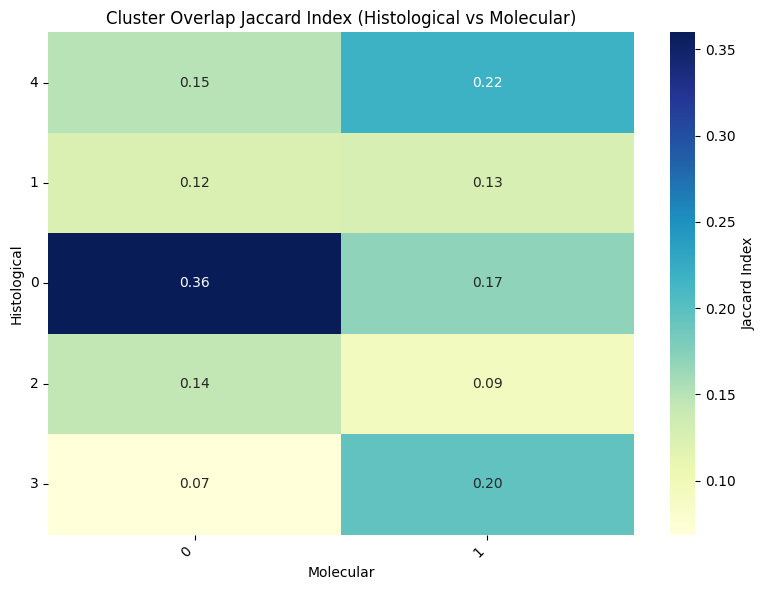


--- Jaccard Index: Histological vs Integrative ---


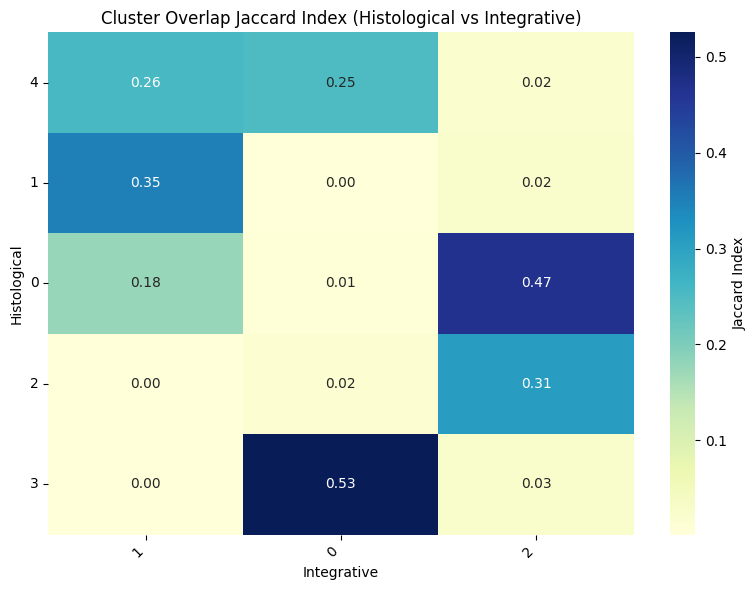


--- Jaccard Index: Molecular vs Integrative ---


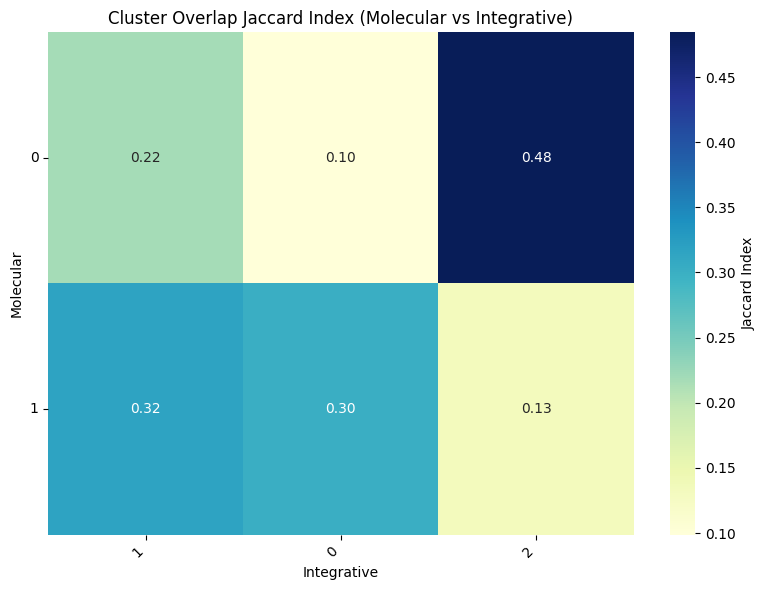

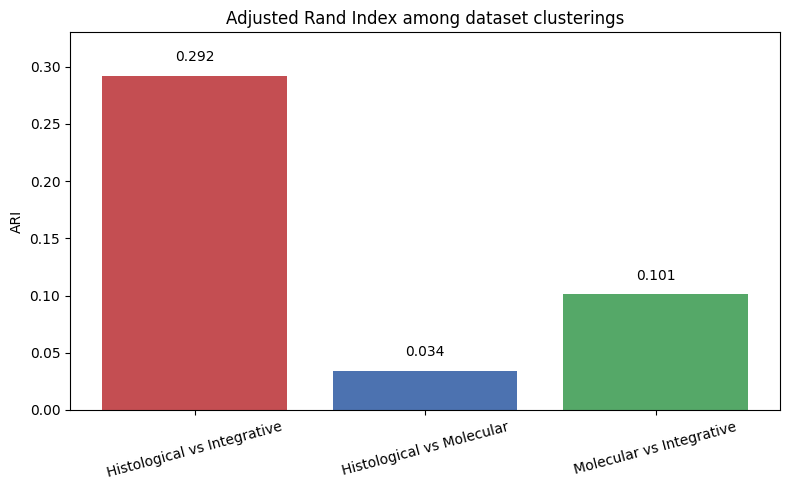

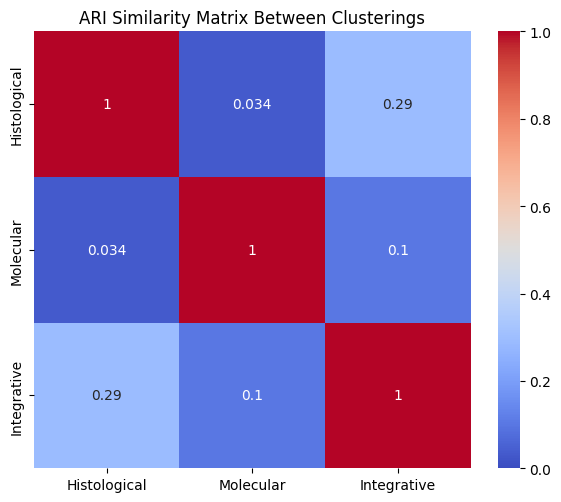

In [50]:
# Function to compute Jaccard Index
def calculate_jaccard(adata1, cluster_col1, adata2, cluster_col2, label1="", label2="", title_suffix=""):
    """ Computes the Jaccard Index matrix between clusters from two AnnData objects and displays a heatmap of cluster overlaps. """
    # Identify common cells
    common_cells = adata1.obs_names.intersection(adata2.obs_names)

    # Build cluster-to-cell dictionaries
    clusters1 = adata1.obs[cluster_col1].unique()
    clusters2 = adata2.obs[cluster_col2].unique()

    clusters_cells1 = {c: set(adata1.obs.loc[common_cells][adata1.obs.loc[common_cells, cluster_col1] == c].index) 
                       for c in clusters1}
    clusters_cells2 = {c: set(adata2.obs.loc[common_cells][adata2.obs.loc[common_cells, cluster_col2] == c].index) 
                       for c in clusters2}

    # Compute Jaccard Index matrix
    jaccard_matrix = pd.DataFrame(index=clusters1, columns=clusters2, dtype=float)
    for c1 in clusters1:
        for c2 in clusters2:
            union = len(clusters_cells1[c1] | clusters_cells2[c2])
            intersection = len(clusters_cells1[c1] & clusters_cells2[c2])
            jaccard_matrix.loc[c1, c2] = intersection / union if union > 0 else 0.0

    # Plot heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(jaccard_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={"label": "Jaccard Index"})
    plt.title(f"Cluster Overlap Jaccard Index {title_suffix}")
    plt.ylabel(label1)
    plt.xlabel(label2)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return jaccard_matrix


# Dataset and cluster column dictionary
datasets = {
    "Histological": {"adata": adata_histological_features, "cluster_col": "cluster_5_scaled"},
    "Molecular": {"adata": adata_molecular_features, "cluster_col": "cluster_2_scaled"},
    "Integrative": {"adata": adata_integrative_features, "cluster_col": "cluster_3_scaled"}}


# Compute Jaccard Index between all dataset pairs
dataset_keys = list(datasets.keys())
for i in range(len(dataset_keys)):
    for j in range(i+1, len(dataset_keys)):
        d1, d2 = dataset_keys[i], dataset_keys[j]
        print(f"\n--- Jaccard Index: {d1} vs {d2} ---")
        _ = calculate_jaccard(
            datasets[d1]["adata"], datasets[d1]["cluster_col"],
            datasets[d2]["adata"], datasets[d2]["cluster_col"],
            label1=d1, label2=d2,
            title_suffix=f"({d1} vs {d2})")


# Compute ARI between all dataset pairs
ari_results = {}
for i in range(len(dataset_keys)):
    for j in range(i+1, len(dataset_keys)):
        d1, d2 = dataset_keys[i], dataset_keys[j]
        common_cells = datasets[d1]['adata'].obs_names.intersection(datasets[d2]['adata'].obs_names)
        labels1 = datasets[d1]['adata'].obs.loc[common_cells, datasets[d1]['cluster_col']]
        labels2 = datasets[d2]['adata'].obs.loc[common_cells, datasets[d2]['cluster_col']]
        ari = adjusted_rand_score(labels1, labels2)
        ari_results[f"{d1} vs {d2}"] = ari


# Plot ARI as bar chart (centered around Histological vs Molecular)
# Desired order for plotting
bar_order = ["Histological vs Integrative", "Histological vs Molecular", "Molecular vs Integrative"]

# Get values in desired order
ari_values_ordered = [ari_results[key] for key in bar_order]

plt.figure(figsize=(8,5))
colors = ['#C44E52', '#4C72B0', '#55A868']  # Custom colors
bars = plt.bar(bar_order, ari_values_ordered, color=colors)

# Annotate values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}", ha="center", va="bottom", fontsize=10)

plt.title("Adjusted Rand Index among dataset clusterings")
plt.ylabel("ARI")
plt.ylim(0, 0.33)
plt.xticks(rotation=15, ha='center')
plt.tight_layout()
plt.show()


# ARI Matrix as Heatmap
ari_matrix = pd.DataFrame(index=dataset_keys, columns=dataset_keys, dtype=float)
for i in dataset_keys:
    for j in dataset_keys:
        if i == j:
            ari_matrix.loc[i,j] = 1.0
        elif f"{i} vs {j}" in ari_results:
            ari_matrix.loc[i,j] = ari_results[f"{i} vs {j}"]
        elif f"{j} vs {i}" in ari_results:
            ari_matrix.loc[i,j] = ari_results[f"{j} vs {i}"]
        else:
            ari_matrix.loc[i,j] = np.nan

plt.figure(figsize=(6,5))
sns.heatmap(ari_matrix, annot=True, cmap="coolwarm", square=True, vmin=0, vmax=1)
plt.title("ARI Similarity Matrix Between Clusterings")
plt.tight_layout()
plt.show()